# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
###  Load training, validation and test data from pickle files
import pickle

training_file = "data/train.p"
validation_file= "data/valid.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Basic Summary of Data Set

n_train = X_train.shape[0] # Number of training examples
n_validation = X_valid.shape[0] # Number of validation examples
n_test = X_test.shape[0] # Number of testing examples.

# What's the shape of an traffic sign image?
image_shape = (X_train.shape[1], X_train.shape[2])

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [3]:
### Reading class names from CSV for proper displaying
import csv

CLASSNAMES = {}
with open('signnames.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        CLASSNAMES[row["ClassId"]] = row["SignName"]
NUMCLASSES = len(CLASSNAMES)

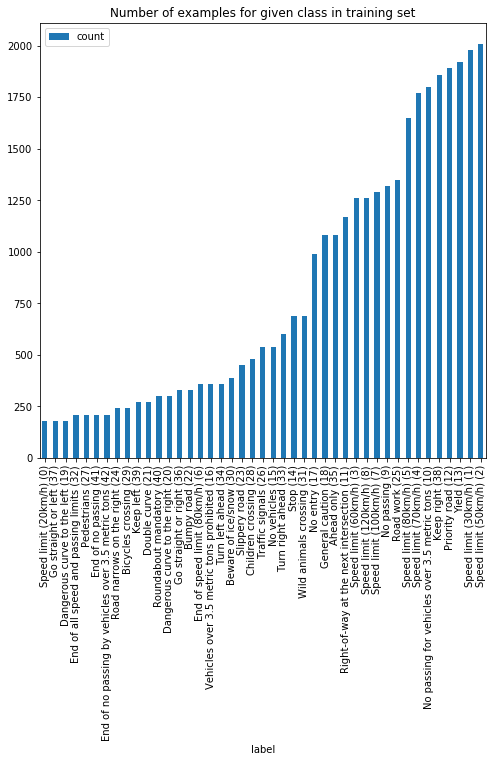

In [4]:
### Are there the same number of examples for every class?
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

# Find the number of all y_train-instances
classes_count = pd.crosstab(index=y_train, columns="count")
# add a few columns for easier display
classes_count["class"] = classes_count.index
classes_count["name"]  = classes_count["class"].apply(str).replace(CLASSNAMES)
classes_count["label"] = classes_count["name"] + " (" + classes_count["class"].apply(str) + ")"
# sort the data
sorted_classes = classes_count.sort_values(by=["count"])
# plot it
sorted_classes.plot(kind="bar", figsize=(8,8), x="label", y="count", \
                    title="Number of examples for given class in training set")

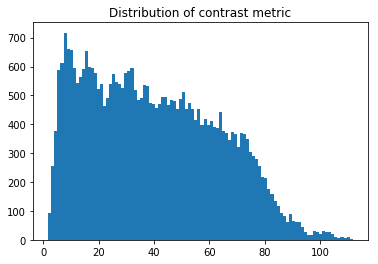

In [5]:
### Pick some very contrast-y images from the data set for
### displaying them as samples.
### Maybe we can even subset the data later and only use the
### most contrast-intensive for training? (Will turn out to 
### be not effective and lead to overfitting.)
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np

# X_ex/y_ex are the feature/label pairs which stand-in
# as prototypes for display of stereotypical images for each class.
y_ex = np.array(range(0,NUMCLASSES))
X_ex = np.empty([y_ex.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3]])
# hold the most contrast-y contrast value for each class, initialize to zero
max_std_ex = np.empty([y_ex.shape[0]])
# also collect the contrast distribution to gauge whether we can subset the data
contrast_distrib = []
# move throught the training data set
for x_val, y_val in zip(X_train, y_train):
    # calculate the contrast value for each image
    x_std = np.std( cv2.cvtColor(x_val, cv2.COLOR_RGB2GRAY).flatten())
    # if this image is more contrast-y than all others ...
    if (x_std >= max_std_ex[y_val]):
        # ... keep it as example
        max_std_ex[y_val] = x_std
        X_ex[y_val] = x_val
    contrast_distrib.append(x_std)

# Plot distribution of contrasts
plt.hist(contrast_distrib, bins=100)
plt.title("Distribution of contrast metric")
plt.show()

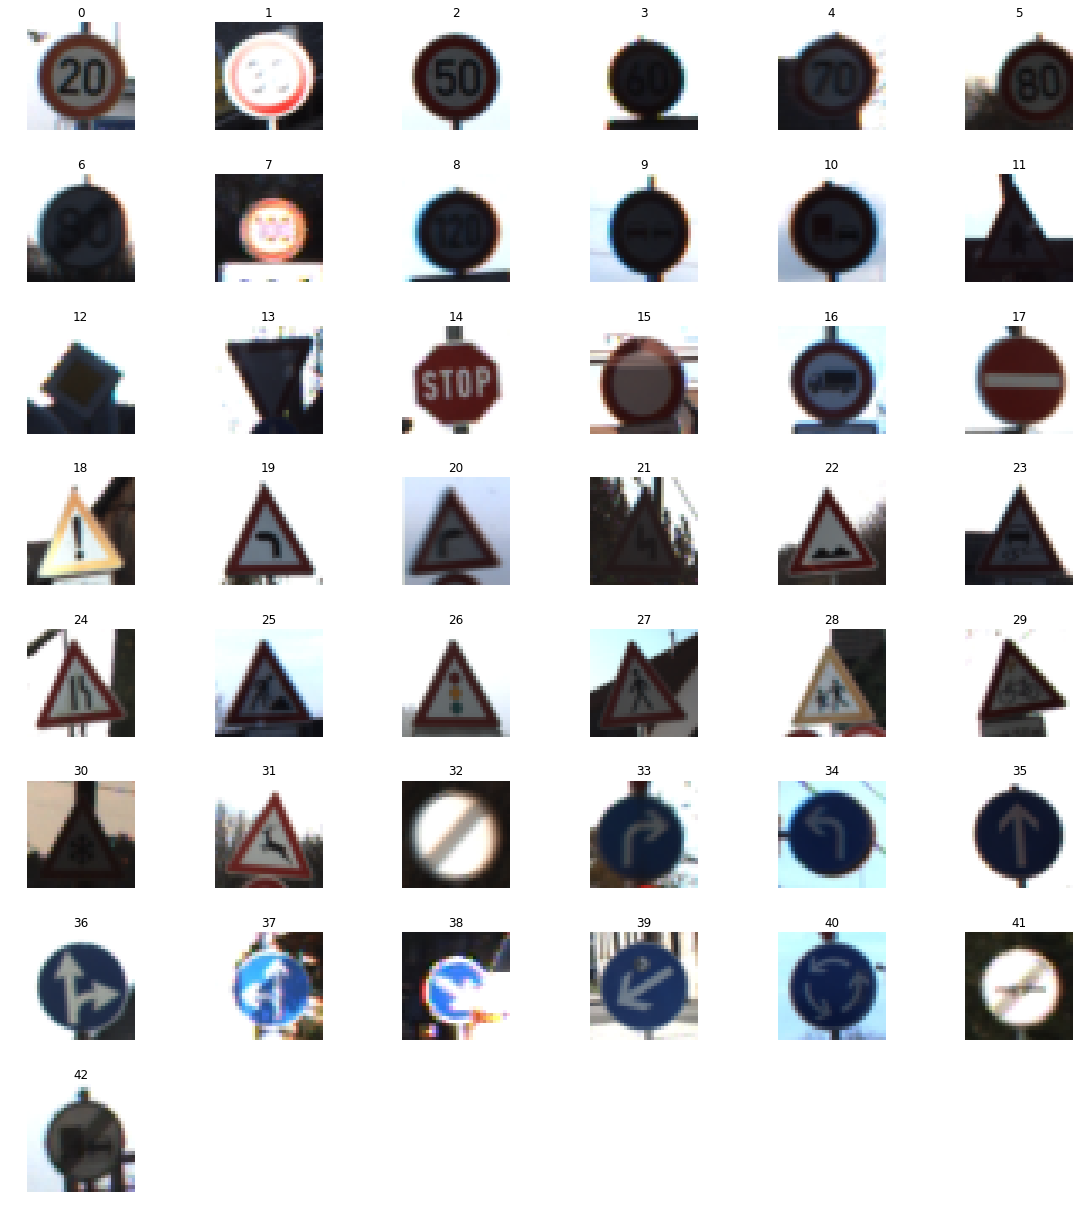

In [6]:
### Plot the most contrast-y traffic signs we found above
def plot_signs(X, y, disp_scale=1):
    # Table of 6 times however many images we need
    plot_w = 6
    plot_h = np.ceil(X.shape[0]/plot_w)
    # Initialize subplot sizes
    plt.subplots(figsize=(16, 17))
    # Move through data and plot it
    counter = 1
    for (x_val, y_val) in zip(X, y):
        plt.subplot(plot_h, plot_w, counter), plt.axis("off"), plt.title(y_val), plt.tight_layout(), plt.imshow(x_val/255)
        counter += 1
        
# Plot only the example images
plot_signs(X_ex, y_ex, disp_scale=5)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [7]:
### Preprocess the data. This includes grayscaling, normalization ("preprocess") and padding 
### the data in a way that there are equal number of examples for every class ("equalizing").
from sklearn.utils import shuffle
import numpy as np

# handles grayscaling and normalization of images
def preprocess(X):
    # N = number of images in set
    N = X.shape[0]
    # gray images have just one channel so we first drop the last dimension
    X_result = np.empty([N, X.shape[1], X.shape[2]])
    # move through the data
    for i, x_val in zip(range(N), X):
        # convert every value to grayscale and store back to array
        x_gray = cv2.cvtColor(x_val, cv2.COLOR_RGB2GRAY)
        X_result[i] = x_gray
    # zero mean and 1 stdev, also reshape to include the last dimension (with length 1 now)
    # this will make it easier to re-use the LeNet-architecture
    return (X_result.reshape([N, X.shape[1], X.shape[2], 1]) -128) / 128

# handles padding data set with data points so that same number of items is present for
# each class. 
def equalize(X, y):
    # dictionary that will contain:
    # key = class-id
    # value = indices in dataset that have that value
    i_classes = {}
    # number of items
    N = X.shape[0]
    # iterate over all classes and construct i_classes
    for i, y_val in zip(range(N), y):
        if y_val not in i_classes:
            i_classes[y_val] = []
        i_classes[y_val].append(i)
    # find the class with the most number of items
    max_n_class = 0
    for c in i_classes:
        if len(i_classes[c]) > max_n_class:
            max_n_class = len(i_classes[c])
    # now let's pad all the classes which don't have enough items
    # move through classes
    for c in i_classes:
        # find out how many items this class has
        n_class = len(i_classes[c])
        if max_n_class-n_class > 0:
            # if it doesn't have enough, randomly duplicate some of the classes
            i_classes[c].extend(np.random.choice(i_classes[c], max_n_class-n_class))
    # construct a new dataset from the modified i_classes
    N_new = len(i_classes) * max_n_class
    X_new = np.empty([N_new, X.shape[1], X.shape[2], X.shape[3]])
    y_new = np.empty([N_new])
    counter = 0
    for c in i_classes:
        for i in i_classes[c]:
            X_new[counter] = X[i]
            y_new[counter] = c
            counter += 1
    # shuffle this new dataset to avoid bias during training
    X_new, y_new = shuffle(X_new, y_new)
    return (X_new, y_new)

# the actual preprocessing pipeline:
# 1. normalize + grayscale
X_train_n = preprocess(X_train)
X_valid_n = preprocess(X_valid)
X_test_n = preprocess(X_test)
# 2. for the training: also equalize
X_train_e, y_train_e = equalize(X_train_n, y_train)

# Sanity check: print out how much the training vector has "grown"
print("Training vector dimensions ")
print("  before class size equalization: " + str(X_train_n.shape))
print("  after class size equalization:  " + str(X_train_e.shape))

Training vector dimensions 
  before class size equalization: (34799, 32, 32, 1)
  after class size equalization:  (86430, 32, 32, 1)


### Model Architecture

In [8]:
### Model architecture. This re-uses the "LeNet" architecture from the lab.
import tensorflow as tf
from tensorflow.contrib.layers import flatten

# Hyperparameters
EPOCHS = 10
BATCH_SIZE = 128
LEARN_RATE = 0.001
# Arguments used for tf.truncated_normal, randomly defines variables 
# for the weights and biases for each layer
MU = 0
SIGMA = 0.1

# Helper functions to easily create convolutional, pooling and fully 
# connected layers with a little bit less tensorflow-boilerplate.

def conv(x, i_width, i_height, i_depth, o_width, o_height, o_depth, \
               f_width, f_height, mean, stddev, strides_w=1, strides_h=1, padding='VALID'):
    weights = tf.Variable(tf.truncated_normal(shape=(f_width, f_height, i_depth, o_depth), mean=mean, stddev=stddev))
    strides = [1, strides_h, strides_w, 1]
    bias = tf.Variable(tf.zeros(o_depth))
    output = tf.nn.bias_add(tf.nn.conv2d(x, weights, strides, padding), bias)
    return output

def pool(x, f_width, f_height, strides_w, strides_h, padding='VALID'):
    output = tf.nn.max_pool(x, ksize=[1,f_width,f_height,1], strides=[1,strides_w,strides_h,1], padding='VALID') 
    return output

def full(x, i_depth, o_depth, mean, stddev):
    weights = tf.Variable(tf.truncated_normal(shape=(i_depth, o_depth), mean=mean, stddev=stddev))
    bias = tf.Variable(tf.zeros(o_depth))
    output = tf.nn.bias_add(tf.matmul(x, weights), bias)
    return output

# Tensorflow placeholders that must be filled when running the session
x = tf.placeholder(tf.float32, (None, 32, 32, 1)) # Features
y = tf.placeholder(tf.int32, (None)) # Labels
keep_prob = tf.placeholder(tf.float32) # Keep probability for dropout

# Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6. (was: Input=32x32x3, Output=28x28x12)
conv1 = conv(x, i_width=32, i_height=32, i_depth=1, o_width=28, o_height=28, o_depth=12, \
             f_width=5, f_height=5, mean=MU, stddev=SIGMA)
    
# Activation.
act1 = tf.nn.relu(conv1)
# Pooling. Input = 28x28x12. Output = 14x14x12.
pool1 = pool(act1, f_width=2, f_height=2, strides_w=2, strides_h=2, padding='VALID')

    
# Layer 2: Convolutional. Output = 10x10x32.
conv2 = conv(pool1, i_width=14, i_height=14, i_depth=12, o_width=10, o_height=10, o_depth=32, \
             f_width=5, f_height=5, mean=MU, stddev=SIGMA)
# Activation.
act2 = tf.nn.relu(conv2)
# Pooling. Input = 10x10x32. Output = 5x5x32. (was: Output=5x5x16)
pool2 = pool(act2, f_width=2, f_height=2, strides_w=2, strides_h=2, padding='VALID')
# Flatten. Input = 5x5x16. Output = 800. (was: Output=400)
flat2 = flatten(pool2)
    
# Layer 4: Fully Connected. Input = 800. Output = 400. (was: Input=400, Output=120)
full3 = full(flat2, i_depth=800, o_depth=400, mean=MU, stddev=SIGMA)
# Dropout
drop3 = tf.nn.dropout(full3, keep_prob)
# Activation.
act3 = tf.nn.relu(drop3)

# Layer 5: Fully Connected. Input = 400. Output = 240. (new)
full4 = full(act3, i_depth=400, o_depth=240, mean=MU, stddev=SIGMA)
# Dropout
drop4 = tf.nn.dropout(full4, keep_prob)
# Activation.
act4 = tf.nn.relu(drop4)

# Layer 6: Fully Connected. Input = 240. Output = 166. (was: Input=120, Output=84)
full5 = full(act4, i_depth=240, o_depth=166, mean=MU, stddev=SIGMA)    
# Activation.
act5 = tf.nn.relu(full5)

# Layer 7: Fully Connected. Input = 166. Output = ~42. (was: Input=166, Output=42)
logits = layer6 = full(act5, i_depth=166, o_depth=NUMCLASSES, mean=MU, stddev=SIGMA)

# Neural network boilerplate
one_hot_y = tf.one_hot(y, NUMCLASSES) # One-hot encoding
# Optimization strategy
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = LEARN_RATE)
training_operation = optimizer.minimize(loss_operation)
# Prediction and metrics to grab from final result
prediction = tf.argmax(logits, 1)
correct_prediction = tf.equal(prediction, tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Saver
saver = tf.train.Saver()

### Train the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [9]:
### Training the model, calculating and reporting the accuracy on the 
### training and validation set. For a more detailled analysis of 
### validation set (& also test set) performance see below.

# Validation function, will be used for cross-validation and testing
def evaluate(X_data, y_data):
    N = len(X_data)
    result_accuracy = 0
    result_y_pred = y_data.copy()
    sess = tf.get_default_session()
    # go through dataset in batches
    for offset in range(0, N, BATCH_SIZE):
        # get a batch
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        # run the network with said batch
        y_pred, accuracy = sess.run([prediction, accuracy_operation], 
                                    feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        # update accuracy and predictions
        result_accuracy += (accuracy * len(batch_x))
        result_y_pred[offset:offset+BATCH_SIZE] = y_pred
    # return result
    return (result_accuracy / N, result_y_pred)

In [10]:
### Actual training session that does the number crunching. :)

with tf.Session() as sess:
    # Initialize Variables
    sess.run(tf.global_variables_initializer())
    N_train = len(X_train)
    # Here we go...
    print("Training...")
    print()
    # Train for a number of epochs
    for i in range(EPOCHS):
        # Shuffle the data again (should be random with every new epoch)
        X_train_e, y_train_e = shuffle(X_train_e, y_train_e)
        # run through dataset in batches
        for offset in range(0, N_train, BATCH_SIZE):
            # get a batch
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_e[offset:end], y_train_e[offset:end]
            # train the network
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.75})
        # return the training and validation metrics
        (train_accuracy, train_pred) = evaluate(X_train_e, y_train_e) 
        (valid_accuracy, valid_pred) = evaluate(X_valid_n, y_valid)
        # display runtime information
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(valid_accuracy))
        print()
    # Save weights to file
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.934
Validation Accuracy = 0.859

EPOCH 2 ...
Training Accuracy = 0.980
Validation Accuracy = 0.924

EPOCH 3 ...
Training Accuracy = 0.989
Validation Accuracy = 0.927

EPOCH 4 ...
Training Accuracy = 0.991
Validation Accuracy = 0.942

EPOCH 5 ...
Training Accuracy = 0.989
Validation Accuracy = 0.946

EPOCH 6 ...
Training Accuracy = 0.992
Validation Accuracy = 0.946

EPOCH 7 ...
Training Accuracy = 0.996
Validation Accuracy = 0.960

EPOCH 8 ...
Training Accuracy = 0.998
Validation Accuracy = 0.962

EPOCH 9 ...
Training Accuracy = 0.996
Validation Accuracy = 0.941

EPOCH 10 ...
Training Accuracy = 0.998
Validation Accuracy = 0.956

Model saved


### Validate & Test the Model

In [11]:
### Define some more detailed validation strategies.
from sklearn.metrics import *
import pandas as pd
import numpy as np
from IPython.display import display

# Return high-level, per-class and inter-class metrics.
def calculate_metrics(X, y):
    # ordered list of class-ids
    classes = list(set(y_valid))
    # function to return a vector of class names for a vector of class ids
    classes_to_names = np.vectorize(CLASSNAMES.get)
    # get accuracy and predictions
    (accuracy, pred) = evaluate(X, y)
    # 1. High Level Metrics:
    # with this we can already compute weighted precision, recall and
    # F1-score with sklearn functions
    highlevel = {
        'accuracy': accuracy,
        'precision': precision_score(y, pred, average='weighted'),
        'recall': recall_score(y, pred, average='weighted'),
        'fscore': f1_score(y, pred, average='weighted')
    }
    # 2. Metrics per Class
    # Get per-class metrics
    (precision, recall, fscore, support) = precision_recall_fscore_support(y, pred, labels=classes)
    # Organize them in a pandas data frame that also includes class names
    perclass = pd.DataFrame({
            'name': pd.Series(classes_to_names([str(c) for c in classes])),
            'precision': pd.Series(precision),
            'recall': pd.Series(recall),
            'fscore': pd.Series(fscore)
        })
    # Re-index data frame so the index contains the class numbers
    perclass.index = classes
    # Re-order columns, sort by F-score ascending
    perclass = perclass[['name', 'precision', 'recall', 'fscore']].sort_values(by=['fscore'], ascending=[False])
    # 2. Inter Class Metrics
    # Calculate confusion matrix and find classes that are most often confused with each other
    confusion = confusion_matrix(y, pred)
    # Zero-out diagonal
    np.fill_diagonal(confusion, 0)
    # Find confusion matrix indices for highest-to-lowest matrix value
    # argsort only returns flat indices...
    most_confused_i = np.argsort(confusion, axis=None)
    # ... so we have to "unravel" them back into the original dimension
    (most_confused_y, most_confused_pred) = np.unravel_index(most_confused_i, dims=confusion.shape)
    # Indices represent class values and can directly be put in a dataframe
    # but don't forget to also add the "*_name" (for human readability) and 
    # the actual confusion matrix index
    interclass = pd.DataFrame({
            'y': pd.Series(most_confused_y),
            'pred': pd.Series(most_confused_pred),
            'y_name': pd.Series(classes_to_names([str(c) for c in most_confused_y])),
            'pred_name': pd.Series(classes_to_names([str(c) for c in most_confused_pred])),
            'times': pd.Series([confusion[k][j] for (k, j) in zip(most_confused_y, most_confused_pred)])
        })
    # We end up re-ordering columns, filtering and sorting. Sorting was already
    # done above with argsort(...) but well...
    interclass = interclass[['y','pred','y_name','pred_name','times']][interclass['times']!=0] \
            .sort_values(by='times', ascending=[False])
    # Re-index straight forward by rank in the table
    interclass.index = range(len(interclass))
    # Big finale: return (1.), (2.) & (3.)
    return highlevel, perclass, interclass

# Displays metrics that have previously been computed with "calculate_metrics"
def display_metrics(highlevel, perclass, interclass, figtitle):
    # High level metrics can simply be printed out
    print("High level metrics:")
    print("  Accuracy = ", highlevel['accuracy'])
    print("  Precision = ", highlevel['precision'])
    print("  Recall = ", highlevel['recall'])
    print("  F1 score = ", highlevel['fscore'])
    print()
    # For the most often confused classes, we just return the top-10 of the data frame
    print("Most often confused classes 'y_name' for 'pred_name' (Top-10):")
    display(interclass.head(10))
    # For the per-class precision & recall metrics, we show a scatter plot 
    # and label the classes for every class with precision or recall < 90%
    print("Problematic classes:")
    p = perclass.plot(kind='scatter', x='precision', y='recall', title=figtitle, figsize=(10,10))
    for idx, row in perclass.iterrows():
        if row["precision"] < 0.9 or row["recall"] < 0.9:
            p.annotate(row["name"], xy=(row["precision"], row["recall"]))
    p.plot()
    

#### Validation Set Metrics

High level metrics:
  Accuracy =  0.955555555853
  Precision =  0.95795498264
  Recall =  0.955555555556
  F1 score =  0.954743183211

Most often confused classes 'y_name' for 'pred_name' (Top-10):


,y,pred,y_name,pred_name,times
0,40,12,Roundabout mandatory,Priority road,21
1,5,2,Speed limit (80km/h),Speed limit (50km/h),9
2,21,19,Double curve,Dangerous curve to the left,7
3,21,31,Double curve,Wild animals crossing,7
4,22,29,Bumpy road,Bicycles crossing,6
5,3,5,Speed limit (60km/h),Speed limit (80km/h),6
6,23,19,Slippery road,Dangerous curve to the left,6
7,41,32,End of no passing,End of all speed and passing limits,5
8,8,7,Speed limit (120km/h),Speed limit (100km/h),4
9,0,4,Speed limit (20km/h),Speed limit (70km/h),4


Problematic classes:


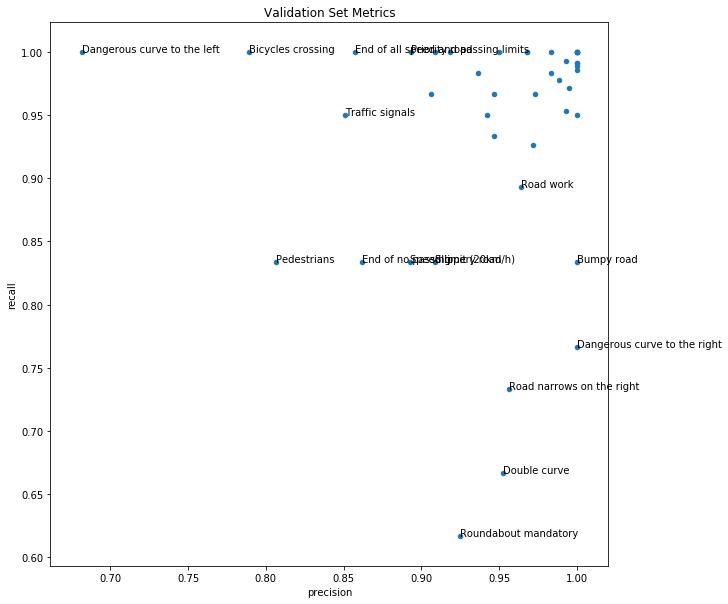

In [12]:
### Show detailed network performance (as defined above) on validation set
%matplotlib inline

with tf.Session() as sess:
    # Restore session
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    # Calculate metrics
    highlevel, perclass, interclass = calculate_metrics(X_valid_n, y_valid)
    # Display metrics
    display_metrics(highlevel, perclass, interclass, 'Validation Set Metrics')

High level metrics:
  Accuracy =  0.925415677026
  Precision =  0.930702261614
  Recall =  0.92541567696
  F1 score =  0.925516581173

Most often confused classes 'y_name' for 'pred_name' (Top-10):


,y,pred,y_name,pred_name,times
0,38,1,Keep right,Speed limit (30km/h),32
1,7,8,Speed limit (100km/h),Speed limit (120km/h),30
2,21,23,Double curve,Slippery road,29
3,24,29,Road narrows on the right,Bicycles crossing,21
4,25,11,Road work,Right-of-way at the next intersection,21
5,18,27,General caution,Pedestrians,20
6,27,25,Pedestrians,Road work,19
7,3,5,Speed limit (60km/h),Speed limit (80km/h),18
8,18,11,General caution,Right-of-way at the next intersection,17
9,38,3,Keep right,Speed limit (60km/h),17


Problematic classes:


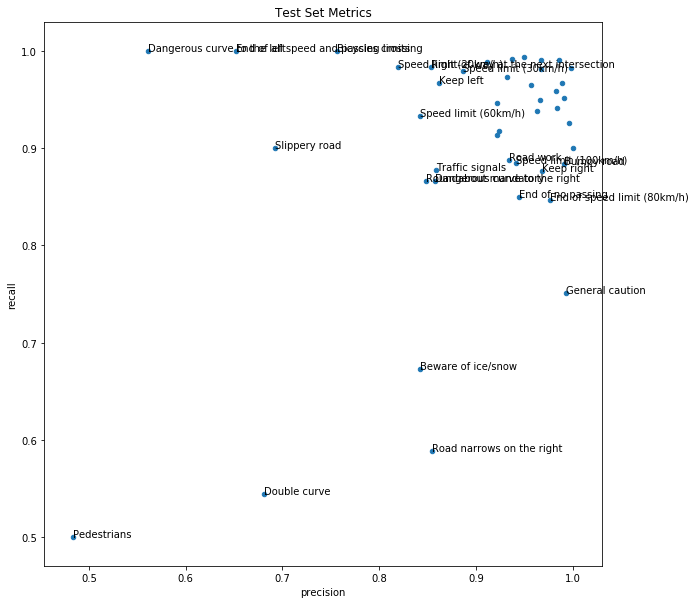

In [13]:
### Show detailed network performance (as defined above) on validation set
%matplotlib inline

with tf.Session() as sess:
    # Restore session
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    # Calculate metrics
    highlevel, perclass, interclass = calculate_metrics(X_test_n, y_test)
    # Display metrics
    display_metrics(highlevel, perclass, interclass, 'Test Set Metrics')

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

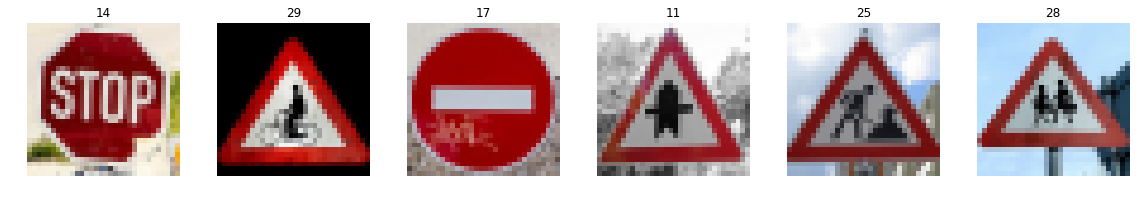

In [14]:
### Load the images and plot them here.
import cv2

# Directory where images are stored & file with image metadata
IMDIR = "images/"
IMDATA = 'images.csv'

# Open file and construct image list
imlist = []
# Go through lines in CSV file IMDATA
with open(IMDATA, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        # Read the Image
        x_orig = cv2.imread(IMDIR + row["filename"])
        # Apply bounding box as defined in CSV file
        x0 = int(row["x0"])
        x1 = int(row["x0"])+int(row["sqsize"])
        y0 = int(row["y0"])
        y1 = int(row["y0"])+int(row["sqsize"])
        x_crop = x_orig[y0:y1, x0:x1]
        # Resize to 32x32
        x_val  = cv2.resize(x_crop, (32,32), interpolation = cv2.INTER_AREA)
        # Store both original and crop/resized image alongside with data
        row["x_orig"] = x_orig
        row["x_val"] = x_val
        imlist.append(row)

# Construct arrays in accordance to the rest of the notebook
X_mine = np.array([image["x_val"] for image in imlist])
y_mine = np.array([image["y_val"] for image in imlist])

# Some additional preprocessing
# endian-ness of files is messed-up (BGR instead of RGB)
X_mine = X_mine[:,:,:,[2,1,0]] 
# same pre-processing is needed as other files
X_mine_n = preprocess(X_mine)

# Plot with same function as used in explorative analysis (Step 1, see above)
plot_signs(X_mine, y_mine)

### Credits for Images

In [15]:
### Print credits (all image are one form of cc-by-* license from Flickr etc.)
for image in imlist:
    print(
        ("Filename: {0}\n" +
        "  URL: {1}\n" + 
        "  Author: {2}\n" +
        "  Author-URL: {3}\n")
        .format(image["filename"], image["url"], image["author"], image["authorurl"]))


Filename: 14081735536_cdd1534c34_m.jpg
  URL: https://www.flickr.com/photos/kevinhackert/14081735536/
  Author: Kevin Hackert
  Author-URL: https://www.flickr.com/photos/kevinhackert/

Filename: 6986126209_52ac2b9140_m.jpg
  URL: https://www.flickr.com/photos/56380734@N05/6986126209/
  Author: Comrade King
  Author-URL: https://www.flickr.com/photos/56380734@N05/

Filename: 14603048095_ec2fb6dd6a_m.jpg
  URL: https://www.flickr.com/photos/a-issleib/14603048095/
  Author: Andreas Issleib
  Author-URL: https://www.flickr.com/photos/a-issleib/

Filename: 7187645956_cf404baf29_m.jpg
  URL: https://www.flickr.com/photos/frogifotos/7187645956/
  Author: fffroggi
  Author-URL: https://www.flickr.com/photos/frogifotos/

Filename: 29539830960_95ce344717_m.jpg
  URL: https://www.flickr.com/photos/27126314@N03/29539830960/
  Author: Margrit
  Author-URL: https://www.flickr.com/photos/27126314@N03/

Filename: 6840546312_a07d9c64a0_m.jpg
  URL: https://www.flickr.com/photos/56380734@N05/6840546312/

### Predict the Sign Type for Each Image / Analyze Performance

In [16]:
### Run the predictions & calculate the accuracy for these 6 images. 

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    (test_accuracy, pred_mine) = evaluate(X_mine_n, y_mine)
    print("Accuracy = {:.3f}".format(test_accuracy))

Accuracy = 0.667


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [17]:
### Print out the top five softmax probabilities for the predictions on 
### the German traffic sign images found on the web. 

# Need a new tensor for that
top_k_predictions = tf.nn.top_k(tf.nn.softmax(logits=logits), k=5)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    # Run the network with that new tensor
    top_k_mine = sess.run(top_k_predictions, feed_dict={x: X_mine_n, keep_prob: 1.0})

# Peek at the output
print("Ouput: {:}".format(top_k_mine))

Ouput: TopKV2(values=array([[  4.51286674e-01,   2.97637820e-01,   1.69509351e-01,
          6.98718205e-02,   9.05218441e-03],
       [  9.99998450e-01,   1.26921520e-06,   2.18135028e-07,
          6.82393946e-08,   1.00270549e-10],
       [  1.00000000e+00,   2.12947238e-12,   3.58586424e-13,
          2.63506881e-13,   1.38241320e-13],
       [  1.00000000e+00,   2.46422687e-08,   2.39572762e-09,
          1.24369751e-10,   1.34088947e-11],
       [  9.99993801e-01,   5.10869768e-06,   9.30999363e-07,
          4.63179681e-08,   2.56097241e-08],
       [  9.99999166e-01,   7.35050833e-07,   7.61090320e-08,
          3.18139515e-10,   1.77089784e-11]], dtype=float32), indices=array([[14,  1,  0,  8,  4],
       [11, 30, 18, 27, 26],
       [17, 34,  0, 40,  9],
       [11, 27, 30, 18, 20],
       [25, 35, 29, 30, 23],
       [11, 30, 23, 16, 42]], dtype=int32))


In [18]:
### Summarize the output of the previous cell a little bit nicer

for image, top_k_pred, top_k_prob in zip(imlist, top_k_mine.indices, top_k_mine.values):
    str_y_val = image["y_val"]
    # Print the image filename, which class it was labeled as ...
    print("image " + image["filename"] + " was " + str_y_val + " (" + CLASSNAMES[str_y_val] + ")")
    # ... whether that was a correct prediction ...
    if str_y_val != str(top_k_pred[0]):
        print("prediction INCORRECT")
    else:
        print("prediction CORRECT")
    # ... output the top-5 softmax probabilities and associated classes.
    for (pred, prob) in zip(top_k_pred, top_k_prob):
        print("p={0:.10f} for {1} ({2})".format(prob, pred, CLASSNAMES[str(pred)]))
    print()

image 14081735536_cdd1534c34_m.jpg was 14 (Stop)
prediction CORRECT
p=0.4512866735 for 14 (Stop)
p=0.2976378202 for 1 (Speed limit (30km/h))
p=0.1695093513 for 0 (Speed limit (20km/h))
p=0.0698718205 for 8 (Speed limit (120km/h))
p=0.0090521844 for 4 (Speed limit (70km/h))

image 6986126209_52ac2b9140_m.jpg was 29 (Bicycles crossing)
prediction INCORRECT
p=0.9999984503 for 11 (Right-of-way at the next intersection)
p=0.0000012692 for 30 (Beware of ice/snow)
p=0.0000002181 for 18 (General caution)
p=0.0000000682 for 27 (Pedestrians)
p=0.0000000001 for 26 (Traffic signals)

image 14603048095_ec2fb6dd6a_m.jpg was 17 (No entry)
prediction CORRECT
p=1.0000000000 for 17 (No entry)
p=0.0000000000 for 34 (Turn left ahead)
p=0.0000000000 for 0 (Speed limit (20km/h))
p=0.0000000000 for 40 (Roundabout mandatory)
p=0.0000000000 for 9 (No passing)

image 7187645956_cf404baf29_m.jpg was 11 (Right-of-way at the next intersection)
prediction CORRECT
p=1.0000000000 for 11 (Right-of-way at the next inte

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [19]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    image_input = preprocess(image_input)
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

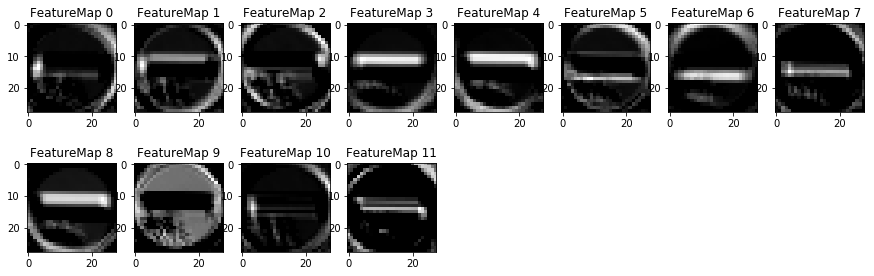

In [20]:
### Output feature map of first activation layer on stop sign

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    outputFeatureMap(X_mine[[2]], act1, plt_num=1)

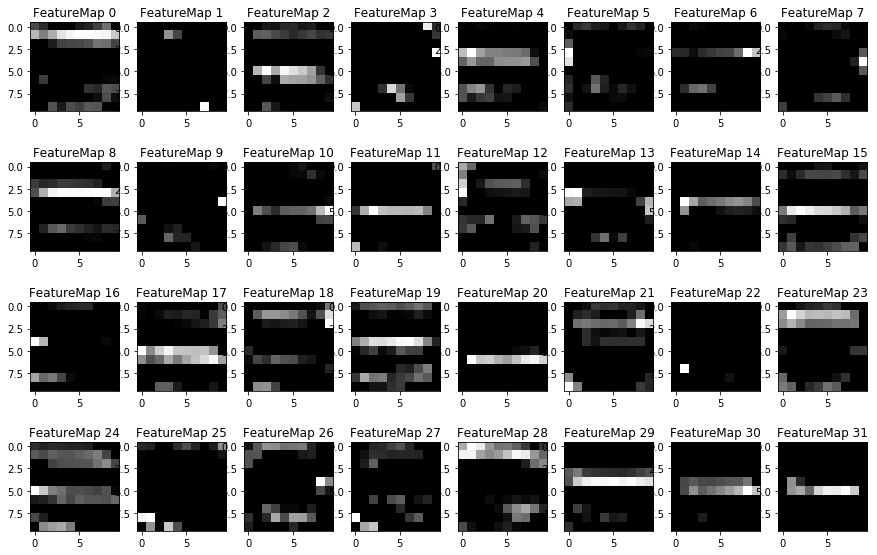

In [21]:
### Output feature map of second activation layer on stop sign

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    outputFeatureMap(X_mine[[2]], act2, plt_num=1)